# Notebook para desenvolvimento do meétodo Kmeans e DBscan para o projeto 1 de Machine learning
 
# Desenvolvido por Felipe Arruda (RA: 196862) e Leonardo Koike (RA: 201332)

# 2021

# Implemetação das funções desse trabalho
Em cada função criada, existe uma documentação explicando detalhadamente o processo de execução desses codigos

In [52]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from typing import Dict, Callable

In [2]:
def initializer_RP(data: np.ndarray, k_cluster: int) -> np.ndarray:
    """Método para inicializar o kmeans. Aqui seguimos a estratégia do algoritmo Random partition.
    Args:
        data (np.ndarray) : array com os dados a serem analisados
        k_cluster (int) : inteiro com o número de cluster
    Return:
        centers_cluster (np.ndarray) : array com as informações dos centroides dos cluster
    """
    # instancia do dicionario
    set_centroids = {}
    # embaralho os dados para ter uma sequencia aleatoria
    np.random.shuffle(data)
    div = data.shape[0]//k_cluster
    # instancia do array para conter o valor dos centroides dos cluster
    centers_cluster = np.ndarray((k_cluster,data.shape[1]))
    # agrupo os dados em cluster aleatórios
    for index in range(k_cluster):
        set_centroids[index] = data[index*div:(index+1)*div,:]
    # tiro o valor médio de cada cluster para obter o centroide
    for idx,value in set_centroids.items():
        centers_cluster[idx] = np.mean(value,axis=0)
    return centers_cluster

In [3]:
def k_means(data: np.ndarray, k_clusters_centers: int) -> np.ndarray:
    """Método de aprendizagem não supervisionado. Através dos dados, o programa aprende a dividir os dados em clusters, definindo um centro para esses clusters.
    Args:
        data (np.ndarray) : Dados que serão utilizados para serem dividos em cluster
        k_cluster_centers (int) : quantidade de cluster
    Return:
        set_centroids (np.ndarray) : array com a posição (coordenada) do centro de cada cluster
    """
    dim = data.shape[1]
    num = data.shape[0]
    # INITIALIZATION
    # Random partition como a inicialização do kmeans, aqui temos ja valores de centroides para os clusters
    list_centroids = initializer_RP(data=data,k_cluster=k_clusters_centers)
    flag = True
    iter = 0
    # LEARNING PART
    # Loop de aprendizagem
    while flag:
        # crio um array para o novo valor de centroide
        new_centroids = np.ndarray((k_clusters_centers,dim))
        # divido os dados entre os cluster. Crio um dicionario com o conjunto dos pontos de cada cluster
        set_centroids = assign_to_cluster(data_in=data,center_cluster=list_centroids)
        # para cada cluster, calculo o novo valor de centroide que é a media dos pontos nesse cluster
        for idx,value in set_centroids.items():
            if value.size == 0:
                pass
            else:
                new_centroids[idx] = np.mean(value,axis=0)
        # verifico se o loop terminou: se as coordenadas do centroides são os mesmos da iteração passada ou se batemos 30 iterações
        if np.all(list_centroids==new_centroids) or iter == 30:
            flag = False
        # se o loop continua, list_centroids recebe o array com os novos valores de centroides e incremento o valor da iteração.
        else:
            list_centroids = new_centroids
            iter += 1
    return new_centroids

In [28]:
def assign_to_cluster(data_in: np.ndarray, center_cluster: np.ndarray) -> Dict[int,np.ndarray]:
    """ Com a posição dos centroides dos cluster fornecidos, cada ponto é relacionado a um cluster segundo a sua distancia euclidiana a esses centroides. A menor distancia significa que o ponto pertence a esse mesmo cluster.
    Args:
        data_in (np.ndarray) : Dados que serão dividos em clusters
        center_cluster (np.ndarray) : Array com a posição dos centroides dos clusters
    Return:
        set_centroids (Dict[int,np.ndarray]) : dicionário relacionando cada cluster com um array dos pontos que pertencem a ele
    """
    # instancia de um dicionario que relaciona cada cluster com os pontos que pertecem a ele
    set_centroids={}
    # para cada cluster, instancio uma lista
    for i in range(center_cluster.shape[0]):
        set_centroids[i] = []
    # garanto que o numero de features é a mesma
    assert center_cluster.shape[1] == data_in.shape[1]
    # para cada dado, verifico qual o centroide mais próximo
    for element in data_in:
        # array com todas as distancias dos centroides
        dist = np.linalg.norm(center_cluster-element,axis=1)
        # esse dado é adicionado ao cluster cujo centroide é o mais próximo
        set_centroids[np.argmin(dist)].append(element.tolist())
    # no final da função, converto a lista em um array numpy
    for center,value in set_centroids.items():
        set_centroids[center] = np.array(value)
    return set_centroids

def assign_to_cluster_index(data_in: np.ndarray, center_cluster: np.ndarray) -> np.ndarray:
    """ Mesma função de cima, porém identifica por elemento qual cluster ela pertence
    Args:
        data_in (np.ndarray) : Dados que serão dividos em clusters
        center_cluster (np.ndarray) : Array com a posição dos centroides dos clusters 
    """
    index_centroid = []
    for element in data_in:
        dist = np.linalg.norm(center_cluster-element,axis=1)
        index_centroid.append(np.argmin(dist)) 
    return np.array(index_centroid)

In [63]:
def elbow(data: np.ndarray, k_max: int = 10) ->  np.ndarray:
    """ Função de elbow que teste e plota um gráfico mostrando qual o melhor valor de k para a solução
    Args:
        data (np.ndarray): dataset a ser utilizado
        k_max (int): quantidade de cluster
    Return:
        set_centroids (Dict[int,np.ndarray]) : dicionário relacionando cada cluster com um array dos pontos que pertencem a ele
    """
    # crio uma array com o somatório do quadrado dos erros
    sse = np.ndarray((k_max,1,))
    # testo de 1 a 9 cluster na entrada da função 
    for i in range(1,k_max):
        center_cluster = k_means(data=data,k_clusters_centers=i)
        # divido o conjunto de dados nos cluster
        set_centroids = assign_to_cluster(data_in=data,center_cluster=center_cluster)
        # inicio o valor do erro em 0
        sse[i] = 0
        # e vou incrementando o valor do quadrado do erro entre o centroide e os pontos desse cluster
        for index,value in set_centroids.items():
            if value.size == 0:
                sse[i] += 0
            else:
                sse[i] += np.sum(np.linalg.norm(value-center_cluster[index],axis=1)**2)
    # ploto o gráfico representativo para analisar qual o melhor valor de k para o problema
    plt.plot(range(1,k_max),sse[1:,:],'ro-')
    plt.xlabel("Quantidade de cluster para o algoritmo k_means")
    plt.ylabel("SSE - Sum of squared error")
    plt.title("Função Elbow")
    plt.show()
    # retorno esse array com a soma do quadrado do erro para cada valor de k.
    return sse[1:,:]

In [6]:
MAX = 1000000000000000
def dunn_index(data: np.ndarray, k_max: int = 10) -> np.ndarray:
    """ Algoritmo que gera um gráfico com os valores de dunn index para cada valor de k da funçãp kmeans
        Args:
            data (np.ndarray): dataset a ser utilizado 
    """
    # instancia do array de resposta
    dunn_index = np.ndarray((k_max,1,))
    max_d = 0
    min_d = MAX
    # teste de 2 a 9 cluster
    for k in range(2,k_max):
        # chamada da função kmeans
        center_cluster = k_means(data=data,k_clusters_centers=k)
        # divisão em cluster de acordo com o valor do centroide desses clusters
        set_centroids = assign_to_cluster(data_in=data,center_cluster=center_cluster)
        # para cada conjunto de pontos nos clusters
        for index, value in set_centroids.items():
            if value.size > 0:
                # pego a máxima distancia dentro dos clusters
                max_d = max(max_d,max_inner_dist(value))
                aux = index+1
                while(aux!=k):
                    if set_centroids[aux].size>0:
                        # minima distancia entre clusters
                        min_d = min(min_d,min_dist_cluster(value,set_centroids[aux]))
                    aux += 1
        # guardo no array a divisao dessa minima distancia entre cluster e da maxima distancia dentro dos clusters
        dunn_index[k] = min_d/max_d
    # ploto o gráfico representativo para analisar 
    plt.plot(range(2,k_max),dunn_index[2:,:],'bo-')
    plt.xlabel("Quantidade de cluster para o algoritmo")
    plt.ylabel("Dunn index")
    plt.title("Gráfico de Dunn index")
    plt.show()
    return dunn_index[2:,:]

def max_inner_dist(data: np.ndarray) -> float:
    max_dist = 0
    for point in data:
        max_dist = max(max_dist,np.max(np.linalg.norm(data-point,axis=1)))
    return max_dist

def min_dist_cluster(cluster1: np.ndarray, cluster2: np.ndarray) -> float:
    min_dist = MAX
    for point in cluster1:
        min_dist = min(min_dist,np.min(np.linalg.norm(cluster2-point,axis=1)))
    return min_dist

In [7]:
def run_and_plot_training(data: np.ndarray, k: int,) -> np.ndarray:
    """ Função que roda o algoritmo do kmeans para os dados de treinamento e plota o gráfico representativo.
    Args:
        data (np.ndarray) : Dados que serão utilizados para rodar o kmeans
        k (int) : Quantidade de cluster
    Return:
        cluster_centers (np.ndarray) : centros dos clusters
    """
    # função k_means em execução, obtenho um array com o centro dos cluster
    cluster_centers = k_means(data=data,k_clusters_centers=k)
    # array de cores para plotar os resultados
    colors = cm.rainbow(np.linspace(0,1,cluster_centers.shape[0]))
    # função assign_to_cluster em execução, obtenho um dicionario que aponta para cada cluster, um array dos pontos que pertecem a esse cluster
    set_clusters = assign_to_cluster(data_in=data,center_cluster=cluster_centers)
    # Plot dos pontos obtidos, dividindo os pontos em suas cores 
    for value,color in zip(set_clusters.values(),colors):
        if(value.size!=0):
            plt.scatter(value[:,0],value[:,1],marker='.',color=color)
    plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X')
    plt.title("Dados de treinamento do algoritmo Kmeans (k=%d)"%k)
    plt.show()
    return cluster_centers

In [8]:
def run_and_plot_testing(data: np.ndarray, cluster_centers: np.ndarray) -> None:
    """ Função que associa cada dado de teste ao seu devido cluster, com base nos centroides dos cluster fornecidos, e plota o gráfico representativo.
    Args:
        data (np.ndarray) : Dados de teste que serão dividos nos clusters
        cluster_centers (np.ndarray) : centros dos clusters
    Return:
        None: nada
    """
    # array de cores para plotar o resultado
    colors = cm.rainbow(np.linspace(0,1,cluster_centers.shape[0]))
    # associa os dados de testes ao cluster
    set_clusters_test = assign_to_cluster(data_in=data,center_cluster=cluster_centers)
    # plot dos pontos de acordo com o seu cluster
    for value,color in zip(set_clusters_test.values(),colors):
        if value.size != 0:
            plt.scatter(value[:,0],value[:,1],marker='>',color=color)
    plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X')
    plt.title("Dados de teste do algoritmo Kmeans e seus clusters")
    plt.show()

# Parte 1 - Clustering Method - Kmeans

## Divisão dos dados de treino e teste
Aqui fizemos uma separação dos dados em uma proporção 90/10
## Pre processamento dos dados
Optamos por uma normalização dos dados, ou seja, dividimos os valores das features pelo valor máximo encontrado nelas. Dessa forma os valores das features estão contidos no espaço entre 0 e 1.

In [9]:
# Dados carregados em um numpy array
data = np.loadtxt('cluster.dat')
np.random.shuffle(data)
# Dados normalizados que serão utilizados como uma comparação 
data_norm = data/data.max(axis=0)
# divisão para dados de treinamento e dados de teste
index = int(data.shape[0]*0.9)
# NORMALIZADOS
norm_train_data,norm_test_data = np.vsplit(data_norm,[index])
# Sem pre processamento
train_data,test_data = np.vsplit(data,[index])

Aqui temos um dataset escolhido pélo nosso grupo. Esse conjunto de dados é referente as informações de cartão de crédito, com 18 features, sendo 17 com valores. Além disso temos 8950 exemplos.
<ul>
<li>BALANCE: Balance amount left in customer's account to make purchases</li>
<li>BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)</li>
<li>PURCHASES: Amount of purchases made from account</li>
<li>ONEOFFPURCHASES: Maximum purchase amount done in one-go</li>
<li>INSTALLMENTS_PURCHASES: Amount of purchase done in installment</li>
<li>CASH_ADVANCE: Cash in advance given by the user</li>
<li>PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)</li>
<li>ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)</li>
<li>PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)</li>
<li>CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid</li>
<li>CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"</li>
<li>PURCHASES_TRX: Number of purchase transactions made</li>
<li>CREDIT_LIMIT: Limit of Credit Card for user</li>
<li>PAYMENTS: Amount of Payment done by user</li>
<li>MINIMUM_PAYMENTS: Minimum amount of payments made by user</li>  
<li>PRC_FULL_PAYMENT: Percent of full payment paid by user</li>
<li>TENURE: Tenure of credit card service for user</li>
</ul>


In [10]:
data_in = pd.read_csv("CC_GENERAL.csv")
data_in

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [11]:
# tratamento de informações sem um valor associado
data_in.drop(['CUST_ID'],axis = 1, inplace = True)
# tratamento de informações em campos nulos
data_in.loc[(data_in['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = data_in['MINIMUM_PAYMENTS'].mean()
data_in.loc[(data_in['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = data_in['CREDIT_LIMIT'].mean()

In [12]:
scaler = StandardScaler()
df = scaler.fit_transform(data_in)
df

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

In [15]:
# divisão dos dados de treino e de teste
np.random.shuffle(df)
index_df = int(df.shape[0]*0.9)
df_train,df_tests = np.vsplit(df,[index_df])

## Treinamento do método kmeans com 2d
Aqui executei a função criada para o kmeans, utilizando diferentes valores de k. No entanto aqui o intuito é treinar e retornar um valor para o centroide dos cluster identificados. Nesses gráficos, os pontos são dividos em cores, que representam qual cluster os dados pertencem.

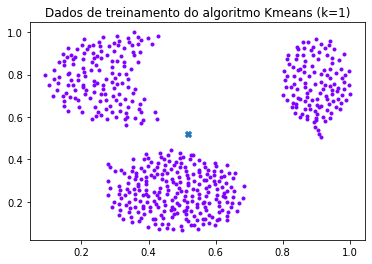

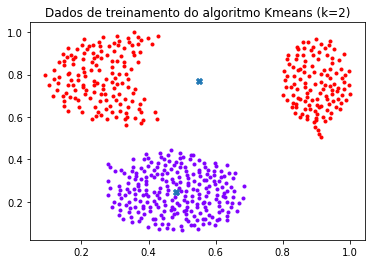

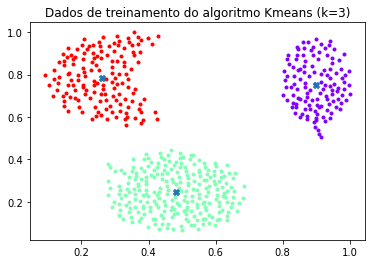

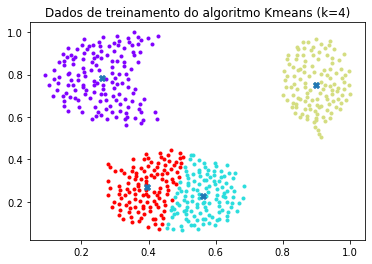

In [16]:
# roda o kmeans com os dados de treino e retorna um array com os centroids
res1 = run_and_plot_training(data=norm_train_data,k=1)
res2 = run_and_plot_training(data=norm_train_data,k=2)
res3 = run_and_plot_training(data=norm_train_data,k=3)
res4 = run_and_plot_training(data=norm_train_data,k=4)

## Treinamento do método kmeans com n dimensões
Aqui executei a função criada para o kmeans, utilizando diferentes valores de k. No entanto diferente dos gráficos 2d, aqui não será possível plotar gráficos

In [37]:
res_m0 = k_means(data=df_train,k_clusters_centers=6)
res_m1 = k_means(data=df_train,k_clusters_centers=7)
res_m2 = k_means(data=df_train,k_clusters_centers=8)
res_m3 = k_means(data=df_train,k_clusters_centers=9)
res_m4 = k_means(data=df_train,k_clusters_centers=10)

## Avaliação de diferentes números de clusters 2d.
Aqui podemos ver melhor o valor ideal de cluster para esses dados. Utilizando a função elbow com a clusterização do kmeans, vemos o valor SSE, ou seja, a soma do quadrado das distâncias dos dados para seu respectivo centroide, isso para cada valor de k. Com o gráfico abaixo podemos ver que <b>o melhor valor para k é o valor 3</b>, que aparece na "ponta do cotovelo" que esse gráfico representa.

<ul>
<li> Por limitação do método kmeans, podemos ver que existem situações onde existem cluster com nenhum conjunto de ponto, o que provoca uma descontinuidade no gráfico em algumas execuções.</li> 
</ul>

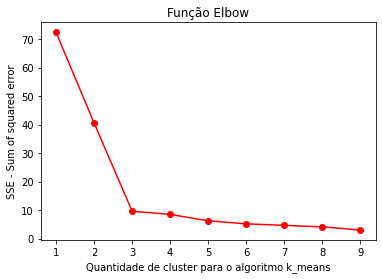

In [66]:
elb1 = elbow(data=norm_train_data)

## Avaliação de diferentes números de clusters n dimensões.
Agora para um dataset com mais dimensões, temos um elbow mais sofisticado. Com o gráfico abaixo podemos ver que <b>o melhor valor para k não é evidente</b>, mas olhando para os valores podemos considerar um k = 8.

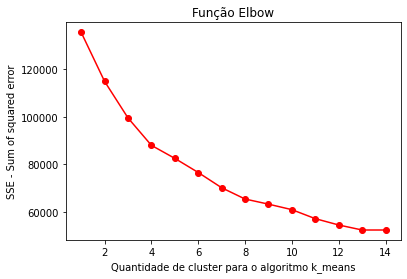

array([[135547.92913357],
       [114924.05838757],
       [ 99544.90817675],
       [ 88017.62241498],
       [ 82535.25798522],
       [ 76591.00499949],
       [ 70187.19930125],
       [ 65435.05914229],
       [ 63279.65667174],
       [ 60963.75902254],
       [ 57180.77196077],
       [ 54513.61065614],
       [ 52403.31226894],
       [ 52402.87587118]])

In [47]:
elbow(data=df_train,k_max=15)

## Métrica de avaliação da clusterização
Aqui utilizamos a métrica da validação interna do Dunn index. Essa função calcula a minima distancia entre clusters em relação ao diametro interna dentro desses clusters. Com isso chegamos em uma número que representa o quanto os clusters são compactos e distantes uns dos outros. Isso representa em features, o quanto um grupo é diferente e único em relação aos outros. Por isso buscamos o máximo valor para ele.

<b>Logo o máximo valor é realmente de k = 3, no entanto esse indice acaba sendo pequeno, devido principalmente aos clusters abrigarem objetos com features parecidas. </b>

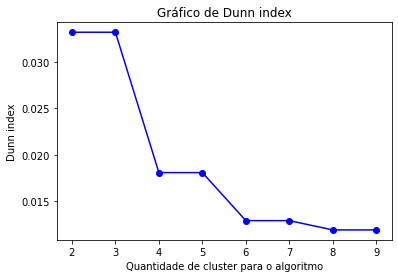

In [20]:
di = dunn_index(data=norm_train_data,k_max=10)

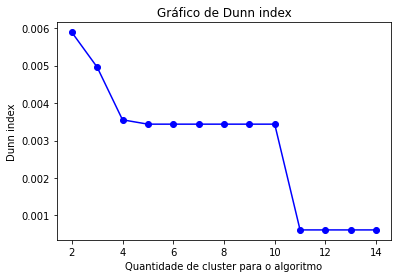

In [21]:
di_n = dunn_index(data=df_train,k_max=15)

## Melhor modelo e utilizando o teste
Como vimos que o melhor modelo é o k = 3, logo aplico o  conjunto de testes para esses valores de centroides. Podemos ver pelo gráfico que os testes se adaptaram bem ao valor dos centroides encontrados na fase de treino.

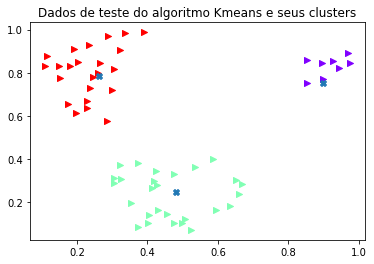

In [22]:
# roda e atribui cada dado de teste ao seu cluster
run_and_plot_testing(data=norm_test_data,cluster_centers=res3)

Para o caso das n dimensões, não é possível ver graficamente, porém podemos ver através do output do dicionário que houve uma divisão em cluster desses pontos de teste.

In [48]:
assign_to_cluster(data_in=df_tests,center_cluster=res_m2)

{0: array([[-0.62541629, -0.24943448,  0.63742352, ..., -0.29450328,
          1.65017998,  0.36067954],
        [-0.73164367,  0.51808382, -0.14687693, ..., -0.28851377,
          2.89345285,  0.36067954],
        [-0.64254411,  0.51808382,  0.63973569, ..., -0.30088972,
          2.32361774,  0.36067954],
        ...,
        [-0.61640996,  0.51808382,  0.70059179, ..., -0.28503832,
          2.58263463,  0.36067954],
        [-0.73798894, -0.63319363, -0.36848076, ..., -0.30783136,
          2.13367499,  0.36067954],
        [-0.71622885,  0.51808382, -0.20993756, ..., -0.29564372,
          2.0387019 ,  0.36067954]]),
 1: array([[-0.58638391,  0.51808382,  1.36854391, ..., -0.28567429,
          0.61411583,  0.36067954],
        [ 0.26358187,  0.51808382, -0.1793925 , ..., -0.1525154 ,
         -0.52555097,  0.36067954],
        [-0.12431457,  0.51808382, -0.2309016 , ...,  0.45720031,
         -0.52555097,  0.36067954],
        ...,
        [ 0.11792085,  0.51808382, -0.34475054, 

# PARTE 2 - Dimensionality reduction
Utilizando o PCA da biblioteca sklearn, podemos reduzir a dimensão do conjunto de dados escolhidos. 

Primeiramente achamos interessante aplicar o PCA somente após o kmeans realizado na primeira parte do dataset com varias features e verificar como ficam representados os cluster. A principio aqui podemos ver que como o kmeans foi executado antes, ele leva em consideração os dados das features originais, o que na hora da representação podemos ter uma vizualização 

In [57]:
# instancia do objeto pca
pca = PCA(n_components=3)
dataframe = pca.fit_transform(df)
pca_df = pd.DataFrame(data=dataframe,columns=['component1','component2','component3'])
cluster = assign_to_cluster_index(data_in= df,center_cluster= res_m2)
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster': cluster})],axis=1)
pca_df

,component1,component2,component3,cluster
0,-1.089332,3.078393,-1.093314,5
1,-1.505906,4.468663,-0.449687,5
2,1.705283,-1.448433,-1.203729,1
3,0.719532,-0.928338,-0.006835,1
4,-0.190541,-1.486650,-1.340886,1
...,...,...,...,...
8945,-1.002117,-1.981117,0.903074,3
8946,-1.486104,0.306050,-0.093596,4
8947,-1.147384,0.803900,0.168119,4
8948,1.890533,-0.353089,-1.015983,1


<ipython-input-62-26b71818f286>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


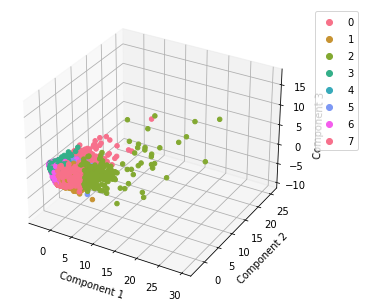

In [62]:
fig = plt.figure()
ax = Axes3D(fig)
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
sc = ax.scatter(pca_df["component1"],pca_df["component2"],pca_df["component3"],c=pca_df["cluster"],cmap=cmap,alpha=1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()